### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    # sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sd_paper/analysis_and_figure_code/DataPaths'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Visualize running behavior for all rats and tally lap #s by hand

In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
# sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
sessions = subjects.remaze_realign_sess()[1:]  # RatSDay2NSD does not have remaze position info

In [3]:
nsd_maze = np.array([25, 23, 163])
nsd_remaze = np.array([17, 30, 103])
sd_maze = np.array([23, 54, 32, 79, 41])
sd_remaze = np.array([16, 4, 4, 92, 10])
for grp, maze_laps, remaze_laps in zip(["NSD", "SD"], [nsd_maze, sd_maze], [nsd_remaze, sd_remaze]):
    print(f"{grp}: maze mean = {maze_laps.mean()} std = {maze_laps.std()}")
    print(f"{grp}: remaze mean = {remaze_laps.mean()} std = {remaze_laps.std()}")

NSD: maze mean = 70.33333333333333 std = 65.53031529164362
NSD: remaze mean = 50.0 std = 37.85058343892029
SD: maze mean = 45.8 std = 19.507947098554478
SD: remaze mean = 25.2 std = 33.6951035018443


In [4]:
[f"{sess.animal.name} {sess.animal.sex} {sess.tag}" for sess in subjects.remaze_realign_sess()]

['RatS female NSD',
 'RatU male NSD',
 'RatV male NSD',
 'RatV male NSD',
 'RatS female SD',
 'RatU male SD',
 'RatU male SD',
 'RatV male SD',
 'RatR female SD']

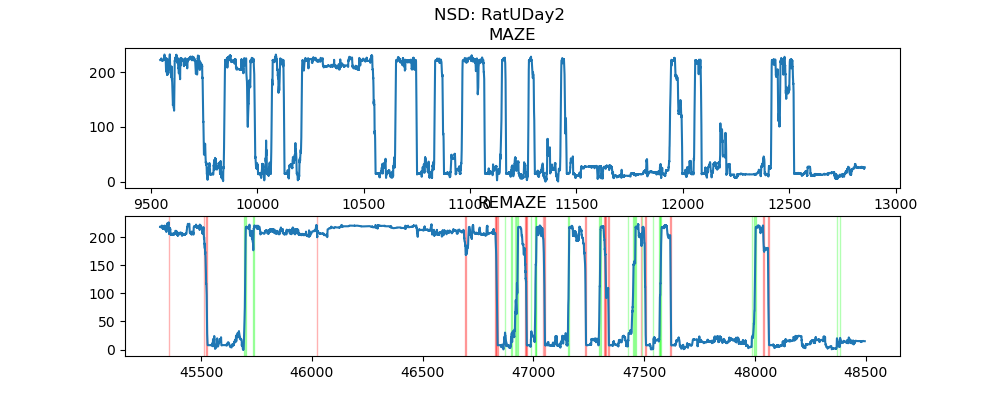

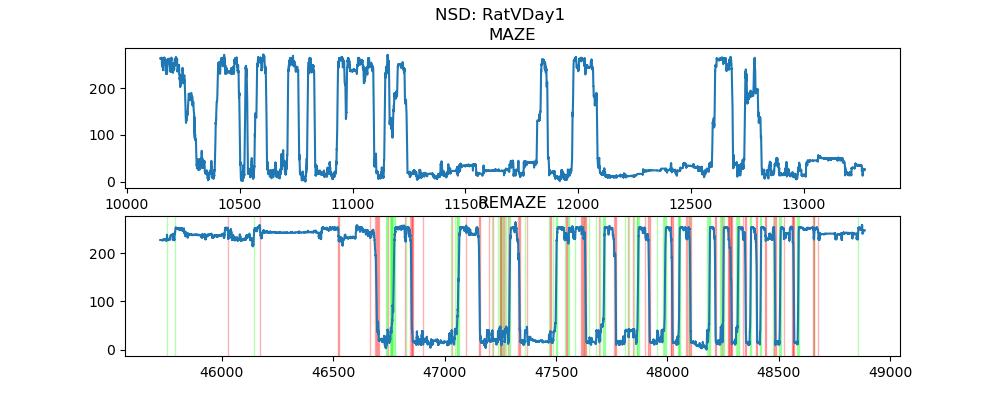

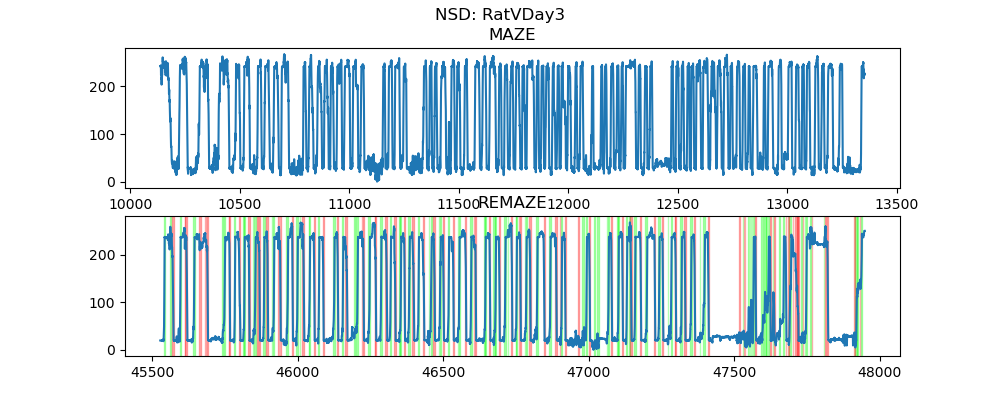

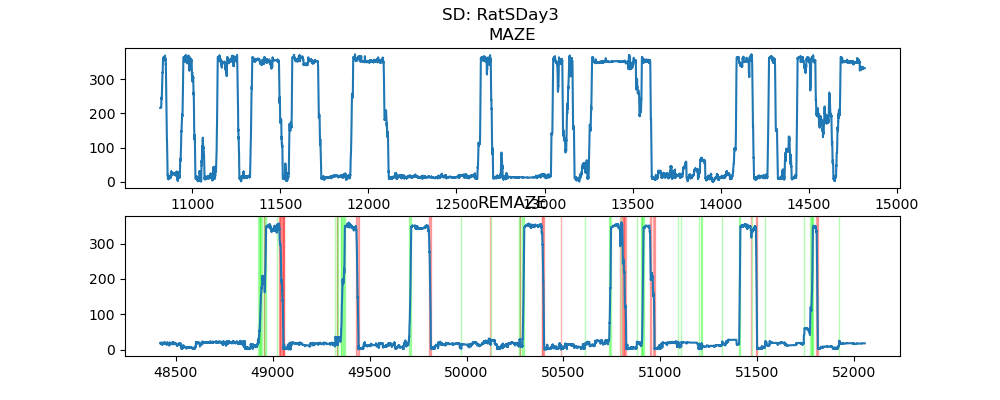

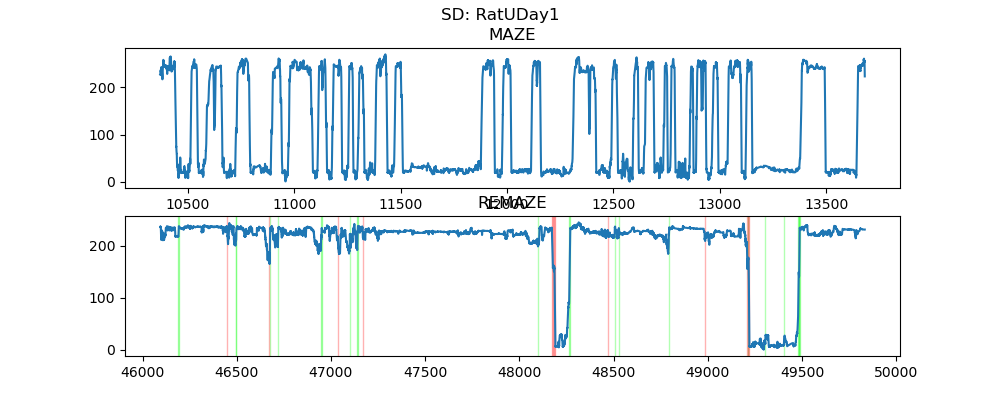

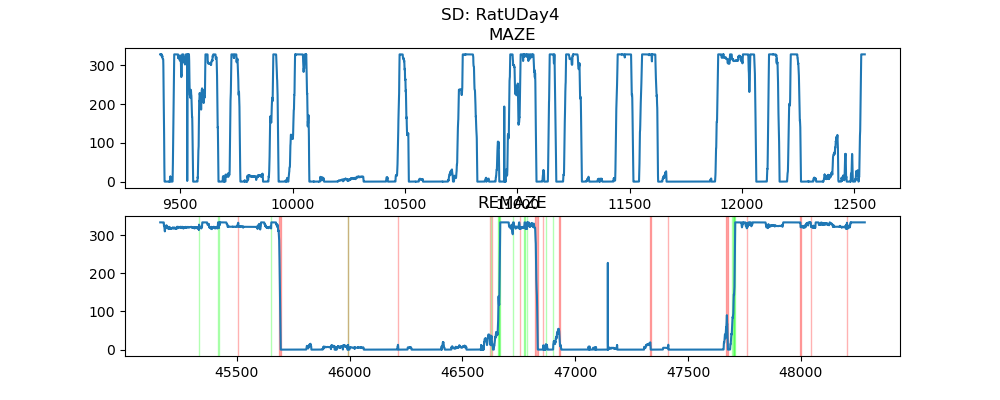

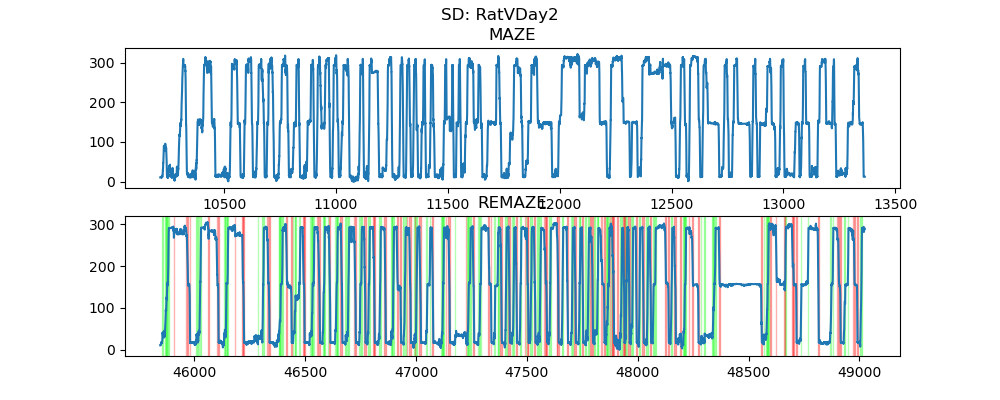

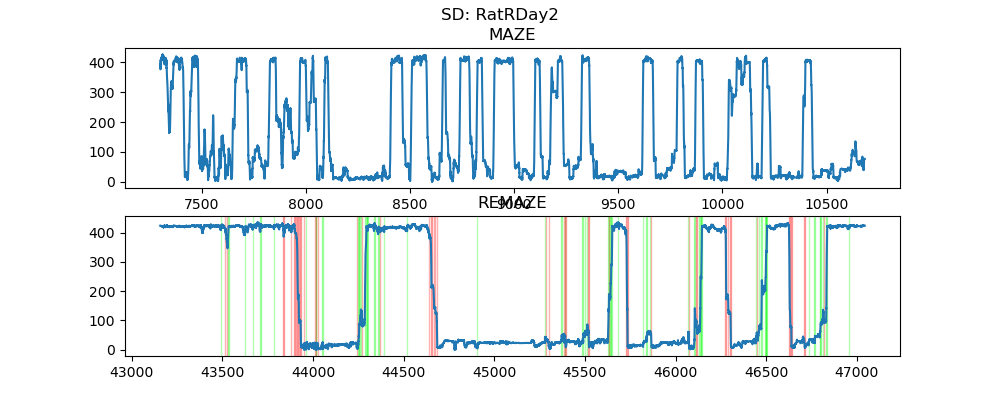

In [5]:
%matplotlib widget
for sess in sessions:
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    fig.suptitle(f"{sess.tag}: {sess.name}")
    ax[0].plot(sess.maze.time, sess.maze.x)
    ax[0].set_title("MAZE")
    ax[1].plot(sess.remaze.time, sess.remaze.x)
    ax[1].set_title("REMAZE")
    for col, dir in zip([[0, 1, 0, 0.3], [1, 0, 0, 0.3]], ["up", "down"]):
        for start, stop in zip(sess.remaze_run[dir].starts, sess.remaze_run[dir].stops):
            ax[1].axvspan(start, stop, color=col)

### Placefields and population vector correlation MAZE vs REMAZE

In [6]:
### Downsample test code - make sure that number of running frames in maze match that of remaze
sess = sessions[0]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")
kw = dict(frate_thresh=0, grid_bin=5)

pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    

Text(0.5, 1.0, 'Downsampled to Match')

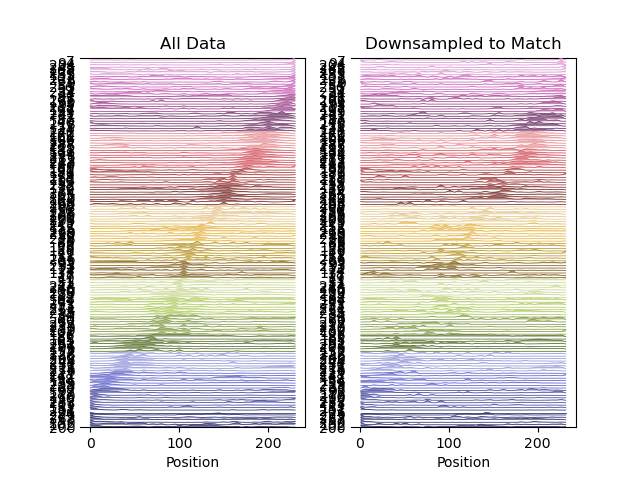

In [7]:
def downsample_maze(pfmaze_in: Pf1D, posmaze_in: Position, nframes_run_match: int, speed_thresh=0, **kw):
    """Downsample pfmaze_in analyses.placefield.Pf1D object to match the input number of frames"""
    # Find frame/time in maze when #frames run is equal to remaze
    maze_speed_bool = pfmaze_in.speed > speed_thresh
    cumsum_maze_run = np.cumsum(maze_speed_bool)
    try:
        run_match_frame = np.where(cumsum_maze_run == nframes_run_match)[0].min()
    except ValueError: # Don't downsample if rat runs more in remaze than maze
        run_match_frame = maze_speed_bool.shape[0]
    # maze_speed_bool[:run_match_frame].sum()
    
    # Cut down on maze time
    t_stop_ds = pfmaze_in.t[run_match_frame]
    maze_pos_ds = posmaze_in.time_slice(t_start=pfmaze.t_start, t_stop=t_stop_ds)
    # maze_times_ds = sess.paradigm["maze"].flatten()
    # # print(maze_times_ds)
    # maze_times_ds[1] = pfmaze.t[run_match_frame]
    # # print(maze_times_ds)
    
    # re-run maze with downsampling
    # pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfmaze_out_ds = Pf1D(neurons, position=maze_pos_ds, **kw)

    return pfmaze_out_ds

# Calculate running frames in remaze
speed_thresh = 3
remaze_speed_bool = pfremaze.speed > speed_thresh
nframes_run_remaze = remaze_speed_bool.sum()

pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_remaze, **kw)

_, ax = plt.subplots(1, 2)
sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[0])
ax[0].set_title("All Data")
plot_ratemap(pfmaze_ds, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[1])
ax[1].set_title("Downsampled to Match")

#### Workhorse code below to aggregate place fields

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/data/GitHub/NeuroPy/neuropy/utils/mathutil.py:101: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/data/GitHub/NeuroPy/neuropy/utils/mathutil.py:101: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/data/GitHub/NeuroPy/neuropy/utils/mathutil.py:101: RuntimeWarning: divide by zero encountered in divide
  return (x - xmin) / xptp
/data/GitHub/NeuroPy/neuropy/utils/mathutil.py:101: RuntimeWarning: invalid value encountered in divide
  return (x - xmin) / xptp


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


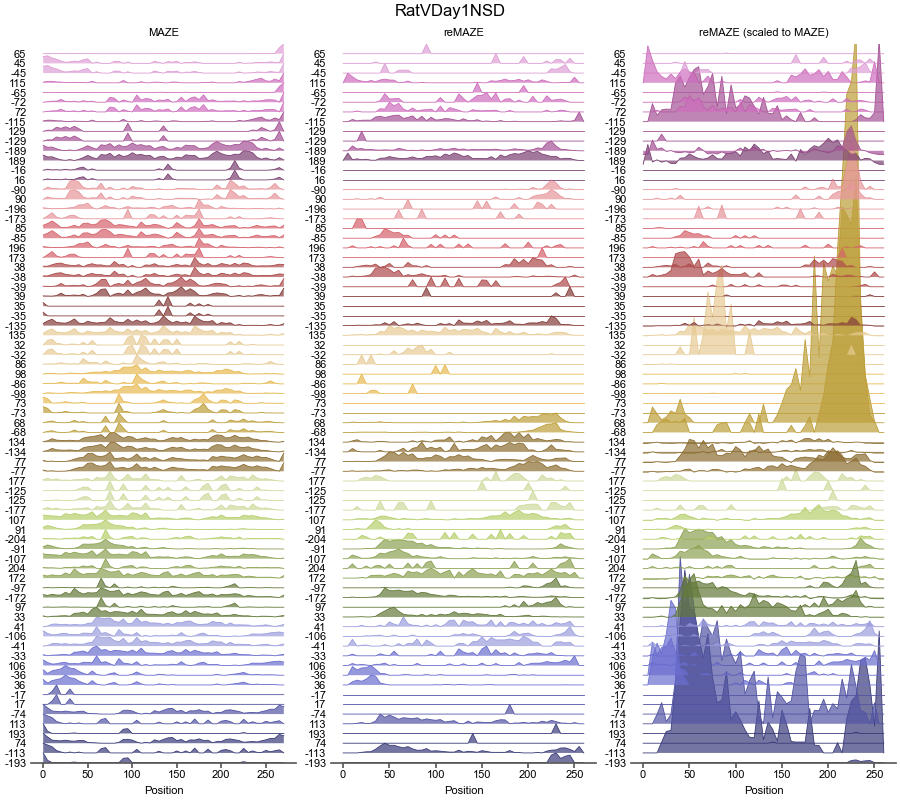

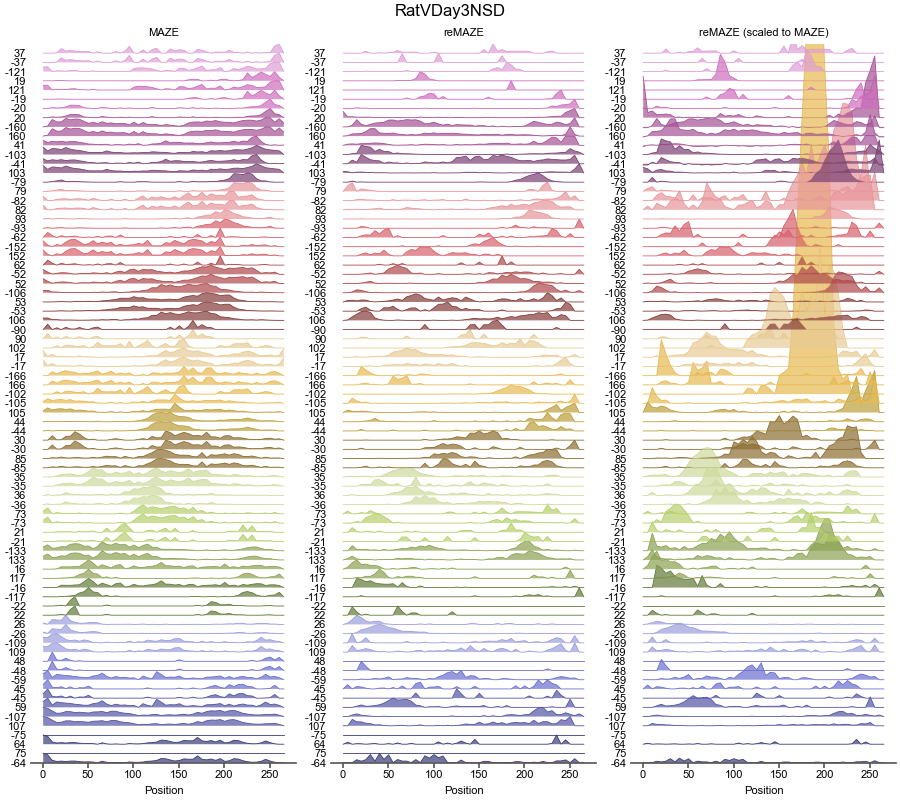

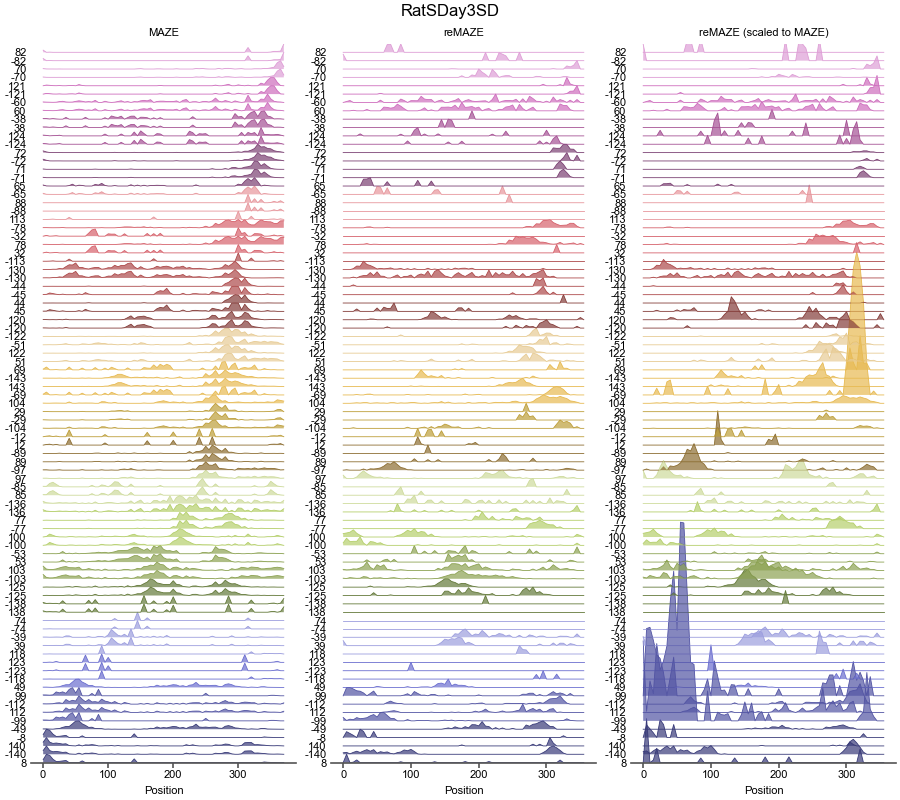

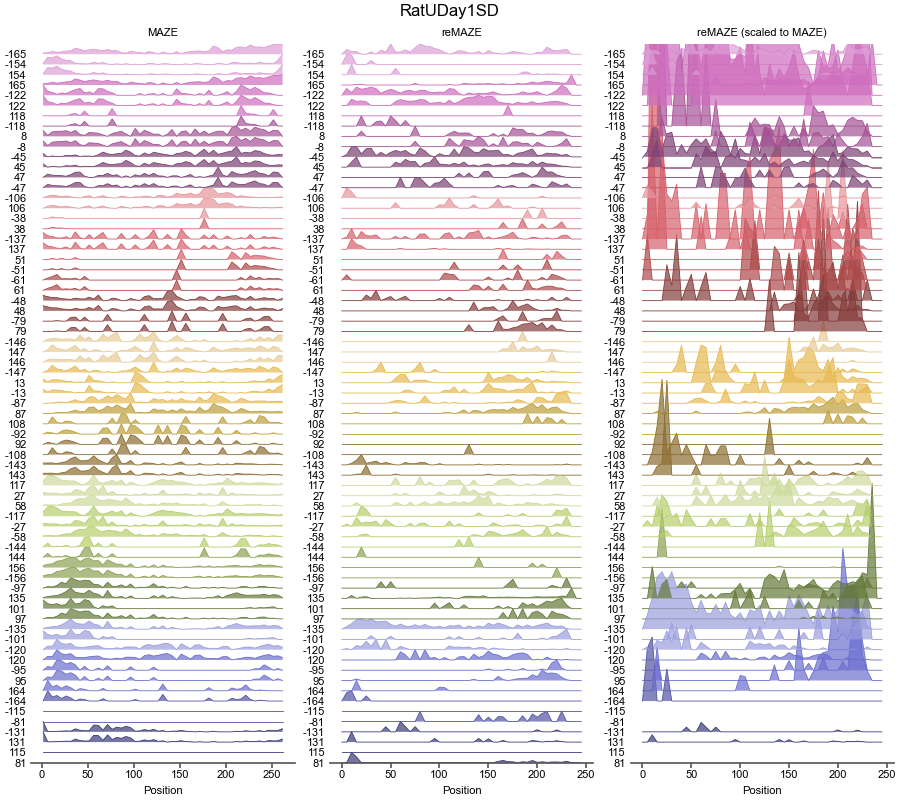

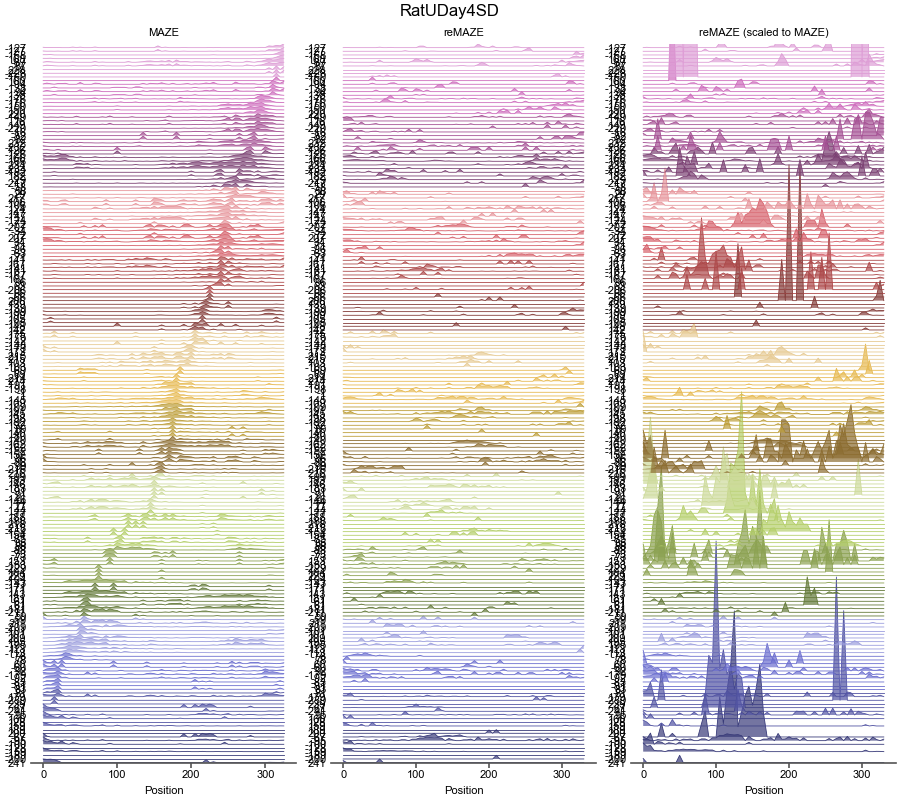

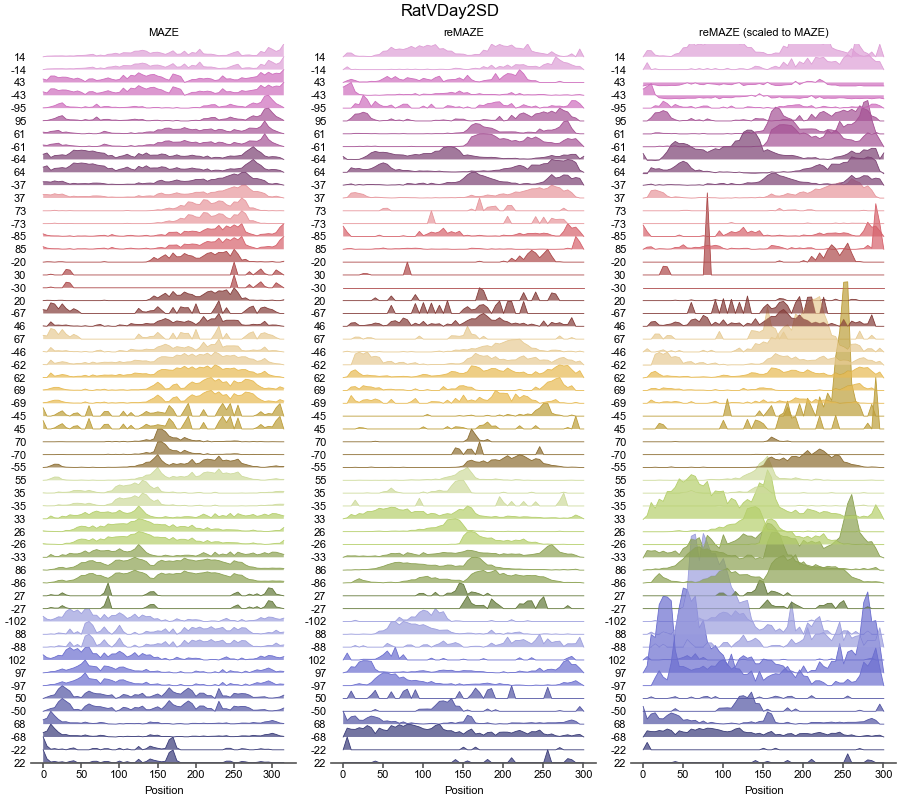

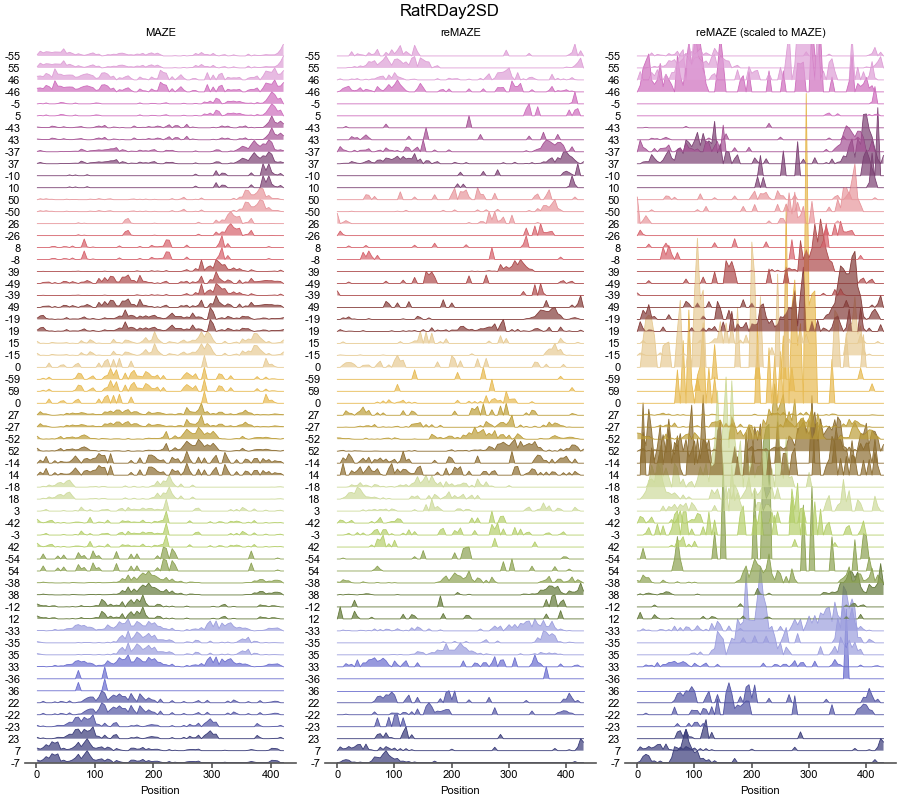

In [19]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

# These parameters are great for producing good fields, but we want to calculate tuning curves first and only then do we want to institute
# our peak FR filter, otherwise we get mismatches in the number and id of cells between sessions as some get filtered out in each.  
# Instead, use the frate_thresh = 3 filter AFTER running Pf1D on all the data
# kw = dict(frate_thresh=3, grid_bin=5, speed_thresh=10)  
kw = dict(frate_thresh=0, grid_bin=5, speed_thresh=10, sigma=0)
sigma2 = 1.5 # additional smoothing for calculating placefield widths, done in bin units, AFTER tuning curve is created
frate_thresh_post_hoc = 3

separate_run_dir = True

# Specify if you want to downsample maze for each session to match remaze
ds_by = "remaze"
assert (ds_by in [None, "remaze"]) or isinstance(ds_by, int)

# Ditto for remaze
ds_remaze_by = None
assert (ds_remaze_by is None) or isinstance(ds_remaze_by, int)

tc_all, maze_all, remaze_all = [], [], []
tc_all_split = []
df_comb = []
pfcorr_by_dir = {}
pf1d_dict = {}
for s, sess in enumerate(sessions):
    pf1d_dict[s] = {"session": s, "grp": sess.tag, "direction": {}}
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    # ---- Run direction separated-------
    if separate_run_dir:
        tc_maze, tc_remaze, maze_tc_comb, remaze_tc_comb = [], [], [], []
        tc_maze_split, tc_remaze_split = [], []
        for direction in ["up", "down"]:
            pf1d_dict[s]["direction"][direction] = {"MAZE": {}, "reMAZE": {}}
            maze_run = sess.maze_run[direction]

            run_bool = sess.maze.speed > kw["speed_thresh"]
            run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
            maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)

            pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run_thresh, sigma_pos=0.1, **kw)
    
            remaze_run = sess.remaze_run[direction]
            rm_run_bool = sess.remaze.speed > kw["speed_thresh"]
            rm_run_epochs = Epoch.from_boolean_array(rm_run_bool, t=sess.remaze.time)
            remaze_run_thresh = remaze_run.intersection(rm_run_epochs, res=1/sess.maze.sampling_rate)
            pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run_thresh, sigma_pos=0.1, **kw)
            fr_max_all = np.vstack((pfmaze.tuning_curves.max(axis=1), pfremaze.tuning_curves.max(axis=1))).T  # Get max firing rate!

            # Downsample maze to match remaze!
            
            if ds_by is not None:
                if ds_by == "remaze":
                    # Calculate running frames in remaze
                    remaze_speed_bool = pfremaze.speed > kw["speed_thresh"]
                    nframes_run_match = remaze_speed_bool.sum()
                elif isinstance(ds_by, int):
                    nframes_run_match = ds_by
            
                pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
                pfmaze = pfmaze_ds

            assert ds_remaze_by is None, "downsampling for remaze not yet tested for separate run directions, which are broken up by epochs"
            if isinstance(ds_remaze_by, int):  # this code needs to be tested, delete assertion above once done!
                pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
                pfremaze = pfremaze_ds

            # Add in reliability information along with between session corrs
            pfmaze_split = Pf1Dsplit(neurons, position=sess.maze, epochs=maze_run_thresh, t_interval_split=60, **kw)
            maze_corrs = pfmaze_split.get_correlations(sigma_bin=sigma2)
            pfremaze_split = Pf1Dsplit(neurons, position=sess.remaze, epochs=remaze_run_thresh, t_interval_split=60, **kw)
            remaze_corrs = pfremaze_split.get_correlations(sigma_bin=sigma2)

            # Mold into dataframe - Method 2
            for pf_use, type in zip([pfmaze, pfremaze, pfmaze_split, pfremaze_split], 
                                    ["MAZE", "reMAZE", "MAZEsplit", "reMAZEsplit"]):
                if type in ["MAZE", "reMAZE"]:
                    df_temp = pd.DataFrame(pf_use.resample_1D(50).tuning_curves)
                    df_temp["FRmax"] = pfmaze.tuning_curves.max(axis=1)
                    df_temp["nid"] = pfmaze.neuron_ids
                    df_temp["block"] = type
                    df_temp["direction"] = direction
                    df_temp["session"] = s
                    df_temp["grp"] = sess.tag
                    df_comb.append(df_temp)
                pf1d_dict[s]["direction"][direction][type] = deepcopy(pf_use)

            # Assemble tuning curves - Method 1
            maze_tc_comb.append(pfmaze.tuning_curves)
            tc_maze.append(pfmaze.resample_1D(50).tuning_curves) # Make curves all the same length
            remaze_tc_comb.append(pfremaze.tuning_curves)
            tc_remaze.append(pfremaze.resample_1D(50).tuning_curves) # Make curves all the same length

            # Assemble split tuning curves
            tc_maze_split.append(np.hstack([pfmaze_split.pf1.resample_1D(50).tuning_curves, 
                                            pfmaze_split.pf2.resample_1D(50).tuning_curves]))
            tc_remaze_split.append(np.hstack([pfremaze_split.pf1.resample_1D(50).tuning_curves, 
                                              pfremaze_split.pf2.resample_1D(50).tuning_curves]))
    
        tc_maze = np.vstack(tc_maze)
        tc_remaze = np.vstack(tc_remaze)
        tc_comb = np.hstack((tc_maze, tc_remaze))
        tc_maze_split = np.vstack(tc_maze_split)
        tc_remaze_split = np.vstack(tc_remaze_split)
        tc_comb_split = np.hstack((tc_maze_split, tc_remaze_split))
        pfmaze.tuning_curves = np.concatenate(maze_tc_comb, axis=0)
        pfmaze.neuron_ids = np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)
        pfremaze.tuning_curves = np.concatenate(remaze_tc_comb, axis=0)
        pfremaze.neuron_ids = np.concatenate((pfremaze.neuron_ids, pfremaze.neuron_ids * -1), axis=0)

    # ---- Overall----
    else:
        direction = "combined"
        pf1d_dict[s]["direction"][direction] = {"MAZE": {}, "reMAZE": {}}

        # Get placefields and apply speed threshold
        maze_run = sess.maze_run
        run_bool = sess.maze.speed > kw["speed_thresh"]
        run_epochs = Epoch.from_boolean_array(run_bool, t=sess.maze.time)
        maze_run_thresh = maze_run.intersection(run_epochs, res=1/sess.maze.sampling_rate)
        pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run_thresh, sigma_pos=0.1, **kw)

        remaze_run = sess.remaze_run
        rm_run_bool = sess.remaze.speed > kw["speed_thresh"]
        rm_run_epochs = Epoch.from_boolean_array(rm_run_bool, t=sess.remaze.time)
        remaze_run_thresh = remaze_run.intersection(rm_run_epochs, res=1/sess.maze.sampling_rate)
        pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run_thresh, sigma_pos=0.1, **kw)
        fr_max = np.vstack((pfmaze.tuning_curves.max(axis=1), pfremaze.tuning_curves.max(axis=1))).T

        # Downsample maze to match remaze! 
        if ds_by is not None:
            if ds_by == "remaze":
                # Calculate running frames in remaze
                remaze_speed_bool = pfremaze.speed > kw["speed_thresh"]
                nframes_run_match = remaze_speed_bool.sum()
            elif isinstance(ds_by, int):
                nframes_run_match = ds_by
        
            pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
            pfmaze = pfmaze_ds

        if isinstance(ds_remaze_by, int):
            pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
            pfremaze = pfremaze_ds

        # Assemble tuning curves - Method 1
        tc_maze = pfmaze.resample_1D(50).tuning_curves
        tc_remaze = pfremaze.resample_1D(50).tuning_curves
        tc_comb = np.hstack((tc_maze, tc_remaze))

        # Add in reliability information along with between session corrs
        pfmaze_split = Pf1Dsplit(neurons, position=sess.maze, epochs=maze_run_thresh, t_interval_split=60, **kw)
        maze_corrs = pfmaze_split.get_correlations(sigma_bin=sigma2)
        pfremaze_split = Pf1Dsplit(neurons, position=sess.remaze, epochs=remaze_run_thresh, t_interval_split=60, **kw)
        remaze_corrs = pfremaze_split.get_correlations(sigma_bin=sigma2)

        # Assemble split tuning curves
        tc_maze_split = [pfmaze_split.pf1.resample_1D(50).tuning_curves, 
                         pfmaze_split.pf2.resample_1D(50).tuning_curves]
        tc_remaze_split = [pfremaze_split.pf1.resample_1D(50).tuning_curves, 
                         pfremaze_split.pf2.resample_1D(50).tuning_curves]
        tc_comb_split = np.hstack((tc_maze_split, tc_remaze_split))

        # Assemble tuning curves into dataframe - Method 2
        for pf_use, type in zip([pfmaze, pfremaze, pfmaze_split, pfremaze_split], 
                                ["MAZE", "reMAZE", "MAZEsplit", "reMAZEsplit"]):
            if type in ["MAZE", "reMAZE"]:
                df_temp = pd.DataFrame(pf_use.resample_1D(50).tuning_curves)
                df_temp["FRmax"] = pfmaze.tuning_curves.max(axis=1)
                df_temp["nid"] = pfmaze.neuron_ids
                df_temp["block"] = type
                df_temp["direction"] = direction
                df_temp["session"] = s
                df_temp["grp"] = sess.tag
                df_comb.append(df_temp)
            pf1d_dict[s]["direction"][direction][type] = deepcopy(pf_use)

    # Now calculate correlations going the same direction or with remaze direction flipped to account for coherent rotations
    corrs_same = np.diagonal(np.corrcoef(tc_maze, tc_remaze), offset=pfmaze.n_neurons)
    corrs_flipped = np.diagonal(np.corrcoef(tc_maze, tc_remaze[:, ::-1]), offset=pfmaze.n_neurons)
    pfcorr_by_dir[sess.name] =  {"remaze_same": corrs_same, "remaze_flipped": corrs_flipped}

    # Aggregate tuning curves! (Method 1)
    maze_all.append(pfmaze.tuning_curves)
    remaze_all.append(pfremaze.tuning_curves)
    tc_comb_df = pd.DataFrame(tc_comb)
    tc_comb_df["session"] = s
    tc_comb_df["grp"] = sess.tag
    tc_all.append(tc_comb_df)

    # Aggregate split tuning curves!
    tc_comb_split_df = pd.DataFrame(tc_comb_split)
    tc_comb_split_df["session"] = s
    tc_comb_split_df["grp"] = sess.tag
    tc_all_split.append(tc_comb_split_df)

    # Now plot place fields for each session individually as a sanity check
    maze_min = np.min(pfmaze.tuning_curves, axis=1)[:, None]
    maze_ptp = np.ptp(pfmaze.tuning_curves, axis=1)[:, None]
    remaze_pf_scaled = min_max_external_scaler(pfremaze.tuning_curves, maze_min, maze_ptp)
    pfremaze_scaled = deepcopy(pfremaze)
    pfremaze_scaled.tuning_curves = remaze_pf_scaled

    # print(f"Check: MAZE has {np.sum(pfmaze.speed > pfmaze.speed_thresh)} and reMAZE has {np.sum(pfremaze.speed > pfremaze.speed_thresh)} running frames")

    fig = Fig(num=f"{sess.name}{sess.tag}", nrows=1, ncols=3, size=(9, 8))
    fig.fig.suptitle(f"{sess.name}{sess.tag}")
    axmaze = fig.subplot(fig.gs[0])
    axremaze = fig.subplot(fig.gs[1])
    axremaze_scaled = fig.subplot(fig.gs[2])
    sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
    plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
    axmaze.set_title('MAZE')
    plot_ratemap(pfremaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
    axremaze.set_title('reMAZE')
    plot_ratemap(pfremaze_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
    axremaze_scaled.set_title('reMAZE (scaled to MAZE)')
    run_flag = "run dir. separate" if separate_run_dir == True else "combined"
    fig.savefig(plot_dir / f"{sess.name}{sess.tag}_maze_remaze_pfs {run_flag}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")
    
    
tc_all = pd.concat(tc_all, ignore_index=True)
tc_all_split = pd.concat(tc_all_split, ignore_index=True)
df_comb = pd.concat(df_comb, axis=0, ignore_index=True)

In [24]:
tc_all.to_csv(group_data_dir / "tc_all.csv")
df_comb.to_csv(group_data_dir / "pf_comb.csv")
np.save(group_data_dir / "pf1d_dict.npy", pf1d_dict)

### Plot individual PFs and PV correlations across MAZE-reMAZE

#### NRK TODO:
1) Implement firing rate threshold to make sure I only keep legit place fields in session 1

In [ ]:
fig = plotting.Fig(12, 8)
ax = fig.subplot(fig.gs[0:2, 0])

In [ ]:
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

fig = plotting.Fig(12, 6)

exclude_nan = False
frate_thresh = 3 # TODO
thresh_method = "maze"  #  "maze" makes sense (only look at legit place cells from first session), "remaze" and "both" could be implemented in the future to assess future field formation...  
sort_by = "MAZE"  # How sort placefields
# Scale activity to overall max across MAZE and reMAZE ("all"), by each maze individually ("by_maze"), or scale to MAZE max ("maze")
scale_row_method = "by_maze" 
assert scale_row_method in ["by_maze", "maze", "all"]
assert sort_by in ["MAZE", "reMAZE"]
corr_all, tc_new_all = [], []
for g, grp in enumerate(["NSD", "SD"]):

    # Grab place field firing as a numpy array

    # Old method
    tc_grp = tc_all[tc_all.grp == grp].drop(columns=["session", "grp"]).to_numpy()
    # tc_grp = gaussian_filter1d(tc_grp, sigma=sigma2, axis=1)
    assert (nbins_per_sesh := int(tc_grp.shape[1]/2)) == tc_grp.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # New method - matches old
    tc_maze_temp = df_comb[(df_comb.grp == grp) & (df_comb.block == "MAZE")].drop(columns=["FRmax", "nid", "block", "direction", "session", "grp"])
    maze_max_fr = df_comb[(df_comb.grp == grp) & (df_comb.block == "MAZE")]["FRmax"]
    tc_remaze_temp = df_comb[(df_comb.grp == grp) & (df_comb.block == "reMAZE")].drop(columns=["FRmax", "nid", "block", "direction", "session", "grp"])
    remaze_max_fr = df_comb[(df_comb.grp == grp) & (df_comb.block == "reMAZE")]["FRmax"]
    nbins_per_sesh = np.shape(tc_maze_temp)[1]
    tc_grp2 = np.hstack((tc_maze_temp.to_numpy(), tc_remaze_temp.to_numpy()))
    tc_grp = tc_grp2
    fr_bool = (maze_max_fr > frate_thresh).values if thresh_method == "maze" else False
    assert isinstance(fr_bool, np.ndarray), "thresh_method other than 'maze' not implemented yet"
    tc_grp = tc_grp[fr_bool]
    tc_grp = tc_grp + np.random.randn(tc_grp.shape[0], tc_grp.shape[1])*1e-10  # Add in random noise to prevent generating nans in PV mat
    
    # Scale each row to its peak firing rate
    tc_new = np.zeros_like(tc_grp)
    if scale_row_method == "by_maze":
        tc_new[:, :nbins_per_sesh] = min_max_scaler(tc_grp[:, :nbins_per_sesh], axis=1)
        tc_new[:, nbins_per_sesh:] = min_max_scaler(tc_grp[:, nbins_per_sesh:], axis=1)
    elif scale_row_method == "all":
        tc_new = min_max_scaler(tc_grp, axis=1)
        print('test')
        # tc_new =  min_max_scaler(tc_grp,axis=-1)
    elif scale_row_method == "maze":
        maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        tc_new[:, :nbins_per_sesh] = min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp)
        tc_new[:, nbins_per_sesh:] = min_max_external_scaler(tc_grp[:, nbins_per_sesh:], maze_min, maze_ptp)
        

    # Sort by MAZE or reMAZE
    if sort_by == "MAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, :nbins_per_sesh], axis=1))
    elif sort_by == "reMAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, nbins_per_sesh:], axis=1))
    tc_new = gaussian_filter1d(tc_new, sigma=1.5, axis=1)
    tc_new_df = pd.DataFrame(tc_new[sort_ind])
    tc_new_df["session"] = tc_all[tc_all.grp == grp].session.values[sort_ind]
    tc_new_df["grp"] = grp
    tc_new_all.append(tc_new_df)
    # print(tc_new.shape)

    # Plot place fields
    ax = fig.subplot(fig.gs[:2, g + 1])
    ax.set_title(grp)
    pf_plot = tc_new[sort_ind, :]
    pf_plot = pf_plot[~np.any(np.isnan(pf_plot), axis=1)] if exclude_nan else pf_plot
    pf_im = ax.pcolormesh(pf_plot, cmap="binary", rasterized=True, vmin=0, vmax=1)
    ax.axvline(nbins_per_sesh, color="k")
    ax.set_xticks([0, nbins_per_sesh, nbins_per_sesh + 1, nbins_per_sesh * 2], [0, 1, 0, 1])
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Position")
    pf_cb = plt.colorbar(pf_im, anchor=(1, 1), shrink=0.3, ticks=[0, 0.9])

    # Plot PV correlations
    ax = fig.subplot(fig.gs[2, g + 1])
    ax.set_title(f"{grp} PV Corrs.")
    corr = gaussian_filter(np.corrcoef(tc_grp.T), 1)
    # corr = np.corrcoef(tc_grp.T)
    np.fill_diagonal(corr, 0)
    corr_all.append(corr)
    corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
    ax.axvline(nbins_per_sesh, color="k")
    ax.axhline(nbins_per_sesh, color="k")
    ax.axis("off")
    corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
fig.savefig(plot_dir / f"maze_remaze_pf_corrs_{sort_by}sorted_{run_flag}.pdf")

In [ ]:
tc_comb = pd.concat(tc_new_all, axis=0)

In [ ]:
maze_sorted = tc_new[:, :nbins_per_sesh]
sort_ind = np.argsort(np.argmax(maze_sorted, axis=1))
maze_sorted = maze_sorted[sort_ind]
remaze_sort_by_maze = tc_new[:, nbins_per_sesh:]
remaze_sort_by_maze = remaze_sort_by_maze[sort_ind]
sort_ind = np.argsort(np.argmax(remaze_sort_by_maze, axis=1))
remaze_ideal = remaze_sort_by_maze[sort_ind]

_, ax = plt.subplots(1, 3, figsize=(3, 4))
pf_im = ax[0].pcolormesh(maze_sorted, cmap="binary", rasterized=True, vmin=0, vmax=1)
ax[0].set_title('MAZE')
pf_im = ax[1].pcolormesh(remaze_sort_by_maze, cmap="binary", rasterized=True, vmin=0, vmax=1)
ax[1].set_title('reMAZE')
pf_im = ax[2].pcolormesh(remaze_ideal, cmap="binary", rasterized=True, vmin=0, vmax=1)
ax[1].set_title('reMAZE sorted')


nshuf = 100
perm_corrs = []
for idn in range(nshuf):
    sort_perm = np.random.permutation(tc_new.shape[0])
    remaze_perm = remaze_ideal[sort_perm]
    perm_corrs.append(np.corrcoef(remaze_ideal.reshape(-1), remaze_perm.reshape(-1))[0][1])

perm_corrs = np.array(perm_corrs)

#### Analysis to quantify sorting of actual reMAZE fields compared to ideal sort
Seems to indicate that SD is CLOSER to the ideal sorting than NSD...

In [ ]:
from copy import copy
def swap_rows(array_in, nswap):
    """Function to randomly swap nrows to determine mean value of place field correlations with n cells remapping"""
    assert array_in.ndim == 2
    
    nrows = array_in.shape[0]
    swap_inds = np.random.choice(np.arange(nrows), nswap, replace=False)

    array_out = copy(array_in)
    array_out[swap_inds] = array_out[np.roll(swap_inds, 1)]
    return array_out

test = np.arange(12).reshape(-1, 2)
swap_rows(test, 3)

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(6, 3))
tc_comb = pd.concat(tc_new_all, axis=0)

nshuf = 100
perm_corrs = {}
for ax, grp in zip(axs, ["NSD", "SD"]):
    tc_new = tc_comb[tc_comb.grp == grp].iloc[:, 0:100].values
    maze_sorted = tc_new[:, :nbins_per_sesh]
    sort_ind = np.argsort(np.argmax(maze_sorted, axis=1))
    maze_sorted = maze_sorted[sort_ind]
    remaze_sort_by_maze = tc_new[:, nbins_per_sesh:]
    remaze_sort_by_maze = remaze_sort_by_maze[sort_ind]
    sort_ind = np.argsort(np.argmax(remaze_sort_by_maze, axis=1))
    remaze_ideal = remaze_sort_by_maze[sort_ind]
    perm_corrs[grp] = {"maze_sorted": maze_sorted, "remaze_sort_by_maze": remaze_sort_by_maze,
                       "remaze_ideal": remaze_ideal}

    swap_mean_corrs = []
    swap_mean_corrs_self = []
    for nrows_swap in range(tc_new.shape[0]):
        temp, temp_self = [], []
        for ns in range(nshuf):
            perm_array = swap_rows(remaze_ideal, nrows_swap)
            temp.append(np.corrcoef(maze_sorted.reshape(-1), perm_array.reshape(-1))[0][1])
            temp_self.append(np.corrcoef(remaze_ideal.reshape(-1), perm_array.reshape(-1))[0][1])
        swap_mean_corrs.append(np.mean(temp))
        swap_mean_corrs_self.append(np.mean(temp_self))
    perm_corrs[grp]["swap_mean_corrs"] = np.array(swap_mean_corrs)
    perm_corrs[grp]["swap_mean_corrs_self"] = np.array(swap_mean_corrs_self)

    ax.set_title(grp)
    ax.plot(swap_mean_corrs, label='mean corr MAZE-reMAZE')
    ax.plot(swap_mean_corrs_self, label='mean corr reMAZE-reMAZE')
    
    maze_remaze_corr = np.corrcoef(maze_sorted.reshape(-1), remaze_sort_by_maze.reshape(-1))[0][1]
    ax.axhline(maze_remaze_corr, linestyle="--", color='k', label='MAZE-reMAZE actual')
    ax.legend()
    ax.set_ylabel("mean PV corr")
    ax.set_xlabel("# cells swapped ideal reMAZE sort")

    ideal_rank = np.sum(maze_remaze_corr > swap_mean_corrs_self)/len(swap_mean_corrs)
    maze_remaze_rank = np.sum(maze_remaze_corr > swap_mean_corrs)/len(swap_mean_corrs)
    ax.text(tc_new.shape[0]/ 2, 0.65, f"r_self={ideal_rank:0.2f}")
    ax.text(tc_new.shape[0]/ 2, 0.55, f"r_maze={maze_remaze_rank:0.2f}")


In [ ]:
_, ax = plt.subplots()
ax.set_title(grp)
ax.plot(swap_mean_corrs, label='mean corr MAZE-reMAZE')
ax.plot(swap_mean_corrs_self, label='mean corr reMAZE-reMAZE')

maze_remaze_corr = np.corrcoef(maze_sorted.reshape(-1), remaze_sort_by_maze.reshape(-1))[0][1]
ax.axhline(maze_remaze_corr, linestyle="--", color='k', label='MAZE-reMAZE actual')
ax.legend()